# Object Detection
> 객체 탐지 논문

- toc: true 
- badges: true
- comments: true
- categories: [python]
- image: images/

---


# 1. R-CNN (2013)
*Rich feature hierarchies for accurate object detection and semantic segmentation*

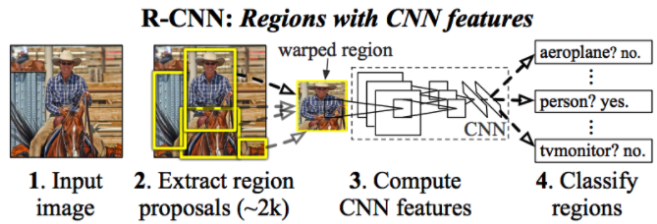

" R-CNN 프로세스 "

1. Image를 입력받는다.

2. Selective search 알고리즘에 의해 regional proposal output 약 2000개를 추출한다.

    (추출한 regional proposal output을 모두 동일 input size로 만들어주기 위해 warp 해준다.
    
    `?` 왜 동일 input size로 만들어 줄까? : 사실 Convolution Layer에는 input size가 고정이지 않다. 그러나 마지막 FC layer에서의 input size는 고정이므로 Convolution Layer에 입력에서부터 동일한 input size로 넣어주어 output size를 동일하게 하는 것)

    
3. 2000개의 warped image를 각각 CNN 모델에 넣는다.

4. 각각의 Convolution 결과에 대해 classification을 진행하여 결과를 얻는다.



위의 과정을 수행하기 위해 R-CNN은 세 가지 모듈로 나누어 놓았다.

- 1. Region Proposal : "Object가 있을법한 영역"을 찾는 모듈 (기존의 Sliding window방식의 비효율성 극복)
    
- 2. CNN : 각각의 영역으로부터 고정된 크기의 Feature Vector를 뽑아낸다.

- 3. SVM : Classification을 위한 선형 지도학습 모델


참고 사이트 : https://ganghee-lee.tistory.com/35

---